In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import signal
from sklearn.cross_decomposition import CCA
from scipy.signal import kaiserord, lfilter, firwin, freqz, butter, filtfilt, convolve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

## Load Dataset

In [2]:
dataset_name = "sultan_psychopy_recordings/eeg_psychopy_sultan_recording_" # 0 to 3
num_targets = 4
targets = [None] * num_targets
channels = ['P7', 'O1', 'O2', 'P8'] # data channels
for i in range(num_targets):
    targets[i] = pd.read_csv(dataset_name+str(i)+'.csv')
    targets[i]['Unnamed: 0'] = [i % 120 for i in range(len(targets[i].index))]
    targets[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)
targets[0].head

<bound method NDFrame.head of       Counter        P7        O1        O2        P8          TIME
0           0  4578.462  3935.897  3865.641  4278.462  1.606509e+09
1           1  4569.231  3936.410  3867.692  4274.359  1.606509e+09
2           2  4570.256  3938.462  3856.923  4275.897  1.606509e+09
3           3  4569.231  3935.385  3847.692  4269.744  1.606509e+09
4           4  4577.436  3946.154  3861.538  4270.769  1.606509e+09
...       ...       ...       ...       ...       ...           ...
8995      115  4609.744  3960.513  3878.974  4308.205  1.606509e+09
8996      116  4600.513  3948.718  3870.256  4290.256  1.606509e+09
8997      117  4606.154  3949.231  3871.282  4288.205  1.606509e+09
8998      118  4603.590  3950.769  3873.846  4293.846  1.606509e+09
8999      119  4596.410  3949.231  3872.308  4292.308  1.606509e+09

[9000 rows x 6 columns]>

In [3]:
# check size - make sure each target is the same length
for i in range(num_targets):
    print('length target {} = {}'.format(i, len(targets[i].index)))

length target 0 = 9000
length target 1 = 9000
length target 2 = 9000
length target 3 = 9000


In [4]:
# copy unfiltered data
original_data = [None] * num_targets
for i in range(num_targets):
    original_data[i] = pd.read_csv(dataset_name+str(i)+'.csv')
    original_data[i]['Unnamed: 0'] = [i % 120 for i in range(len(original_data[i].index))]
    original_data[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)

In [5]:
channels = ['P7', 'O1', 'O2', 'P8']
my_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan', 'tab:gray']
my_labels = ['Target 0', 'Target 1', 'Target 2', 'Target 3', 'Target 4', 'Target 5', 'Target 6', 'Target 7', 'Neutral Target']

def butter_band_targets(targets, low=0.16, high=16.0):
    for i in range(num_targets):
        for channel in channels:
            targets[i][channel] = butter_band(np.asarray(targets[i][channel]), lowcut=low, highcut=high)
    return targets

def butter_highpass_targets(targets):
    for i in range(num_targets):
        for channel in channels:
            targets[i][channel] = butter_highpass(np.asarray(targets[i][channel]))
    return targets

def butter_band(data, s_r=128.0, lowcut=0.16, highcut=50.0, order=5):
    # ------------------------------------------------
    # Create a butterworth bandpass filter and apply it to data.
    # ------------------------------------------------
    nyq = 0.5 * s_r
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    # data = data * 50  # amplify data
    return filtfilt(b, a, data)

def butter_highpass(data, cutoff=0.16, fs=128.0, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

def car_filter_targets(targets):
    # subtract average off all data - list of dataframes
    for i in range(num_targets):
        for channel in channels:
            targets[i][channel] -= np.average(np.asarray(targets[i][channel]))
    return targets

def car_filter_one_channel(data):
    # numpy array - num_samples in one channel
    return data - np.average(data)

In [6]:
def cut_uneven_datasets(df_list):
    # use this function if the datasets are of uneven length - chop to minimum df size
    cutoff_list = [len(df_list[i].index) for i in range(8)]
    cutoff = min(cutoff_list)
    for i in range(len(cutoff_list)):
        keep_indicies = set(range(df_list[i].shape[0])) - set(range(cutoff, df_list[i].shape[0]))
        df_list[i] = df_list[i].take(list(keep_indicies))
        # make sure each df same length
        print('length of dataset {} = {}'.format(i+1, len(templates[i].index)))



# these filtering functions work on each target - only call once
def pca_filter(variance=0.2):
    for i in range(num_targets):
        pca = PCA(variance).fit(targets[i][channels])
        components = pca.transform(targets[i][channels])
        targets[i][channels] = pd.DataFrame(pca.inverse_transform(components))
        
def fir_filter(frequencies=None):
    # if frequencies are not supplied, assume 1 to 50 Hz. Otherwise filter for the target frequency - cheating
    if frequencies is None:
        filt = signal.firwin(400, [3.0, 50.0], pass_zero=False, fs=128.0)
        for i in range(num_targets):
            for channel in channels:
                targets[i][channel] = signal.convolve(np.array(targets[i][channel]), filt, mode='same')
    # trying to filter each channel based on respective target frequencies
    else:
        for i in range(num_targets):
            band_edges = [frequencies[i]-1.0, frequencies[i]+1.0]
            print(band_edges)
            for channel in channels:
                filt = signal.firwin(400, band_edges, pass_zero=False, fs=128.0)
                targets[i][channel] = signal.convolve(targets[i][channel], filt, mode='same')
            
        
def plot_time_all(data, start=0, end=1000, extend_title=''):
    # df plot
    for i in range(num_targets):
        fig, ax = plt.subplots(figsize=(10, 5))
        for channel in channels:
            data[i][channel][start:end].plot(y=channel, title='Target {} Signal Over Time {}'.format(i, extend_title) if i != 8 else 'Neutral Target Signal')
        ax.legend(channels)
        ax.autoscale(axis='y', tight=True)
        
        
def plot_channel(target, channel):
    # assume dataframe
    fig, ax = plt.subplots(figsize=(10, 5))
    target[channel].plot(y=channel, title='{} Signal Over Time'.format(channel))
        
def cut_ends(cutoff=256):
    # this function is used after FIR filtering because the ends have extremely high peaks
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)] + [i for i in range(n-1, n-cutoff-1, -1)]
    for i in range(num_targets):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)
        
def cut_left_end(cutoff=256):
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)]
    for i in range(num_targets):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)
        
        
def plot_averages(averages_all_targets):
    # plot all targets all channels on one plot. possibly messy
    fig, ax = plt.subplots(figsize=(15, 7))
    for i, avg_sig in enumerate(averages_all_targets):
        for channel in channels:
            avg_sig.plot(x='Counter', y=channel, ax=ax, color=my_colors[i], label=my_labels[i] if channel=='P7' else "")
    ax.legend()
    ax.set_title('Average Signals for All Targets and All Channels')
    
def plot_target_average(average, ind):
    # all channels for one target - input is index of targets
    fig, ax = plt.subplots(figsize=(15, 7))
    for j, channel in enumerate(channels):
        average.plot(x='Counter', y=channel, ax=ax, color=my_colors[j], label=channel)
    ax.set_title('Target {} Average Signal for All Channels'.format(ind) if ind != 8 else 'Neutral Target Average Signal for All Channels')
        
def plot_averages_by_channel(averages_all_targets):
    # 4 plots, each with 8 targets + neutral
    for channel in channels:
        fig, ax = plt.subplots(figsize=(15, 7))
        for i, avg_sig in enumerate(averages_all_targets):
            avg_sig.plot(x='Counter', y=channel, ax=ax, color=my_colors[i], label=my_labels[i])
        ax.legend(loc='upper right')
        ax.set_title('Channel {} Average Signals for All Targets'.format(channel))


def averaging(targets):
    averages = []
    cols = ['Counter', 'O1', 'O2', 'P7', 'P8']
    for target in targets:
        average_for_target = pd.DataFrame(columns = cols)
        for i in range(128):
            o1avg = np.average(np.asarray(target.query('Counter == {}'.format(i))['O1']))
            o2avg = np.average(np.asarray(target.query('Counter == {}'.format(i))['O2']))
            p7avg = np.average(np.asarray(target.query('Counter == {}'.format(i))['P7']))
            p8avg = np.average(np.asarray(target.query('Counter == {}'.format(i))['P8']))
            row = {'Counter' : i, 'O1' : o1avg, 'O2' : o2avg, 'P7' : p7avg, 'P8' : p8avg}
            average_for_target = average_for_target.append(row, ignore_index=True)
        
        averages.append(average_for_target)
    return averages

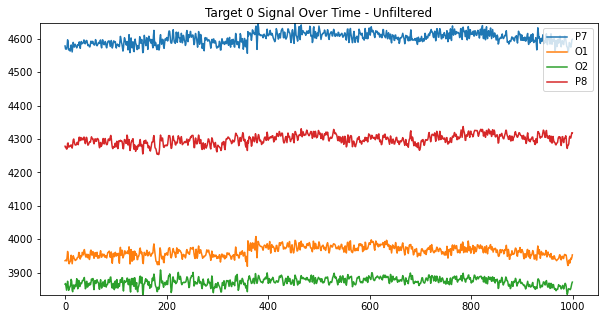

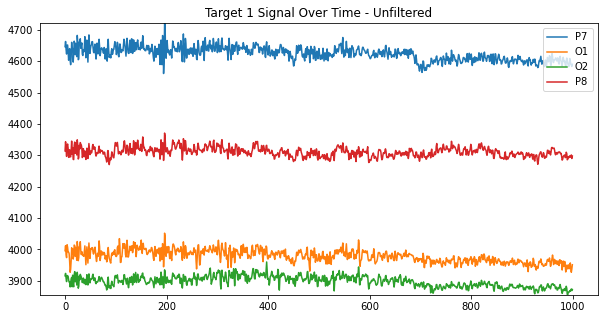

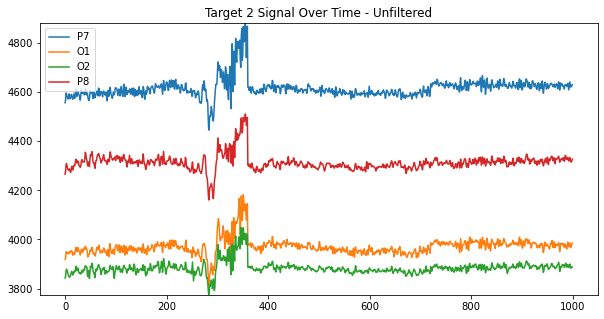

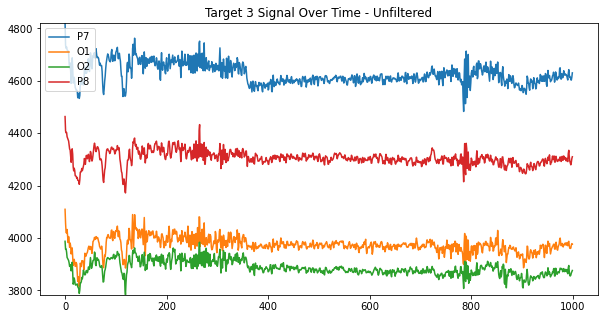

In [7]:
plot_time_all(targets, extend_title='- Unfiltered')

In [8]:
frequencies = [15.0, 12.0, 8.57, 5.45]
targets = car_filter_targets(targets)
# targets = butter_highpass_targets(targets)
# targets = butter_band_targets(targets)

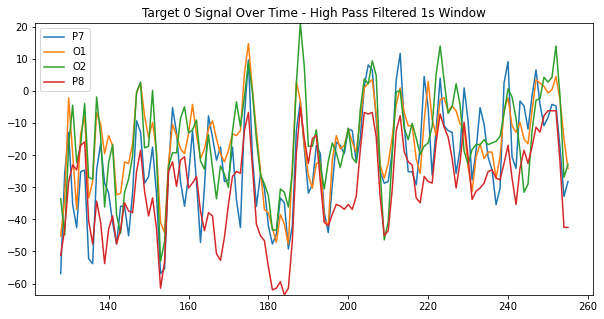

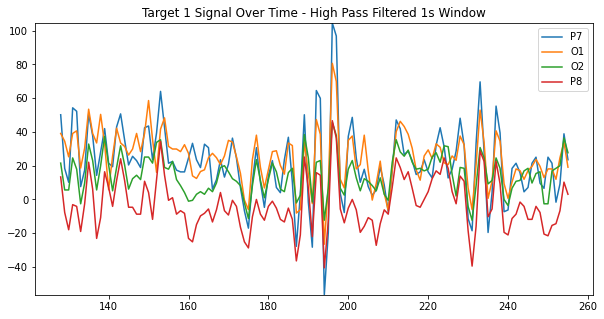

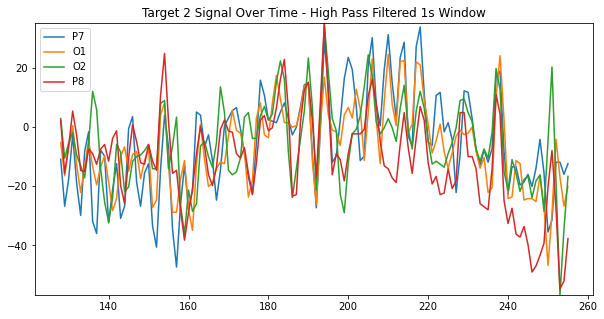

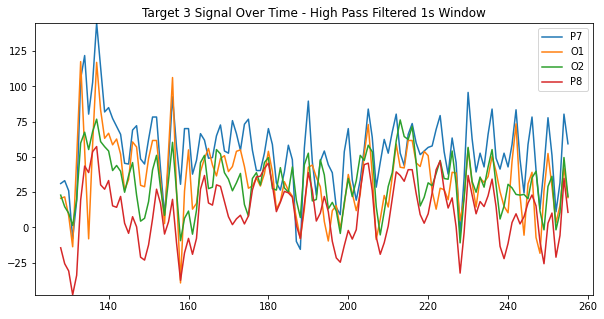

In [9]:
plot_time_all(targets, start=128, end=128*2, extend_title='- High Pass Filtered 1s Window')

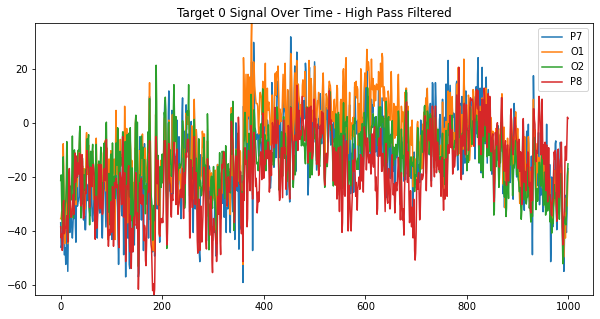

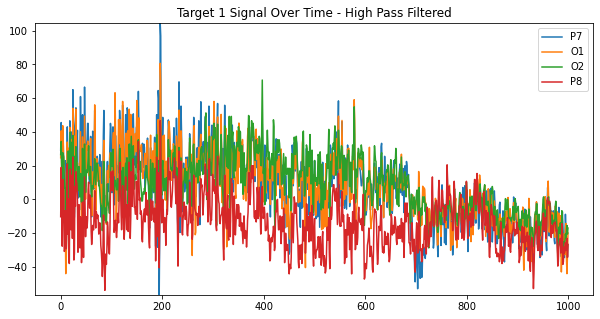

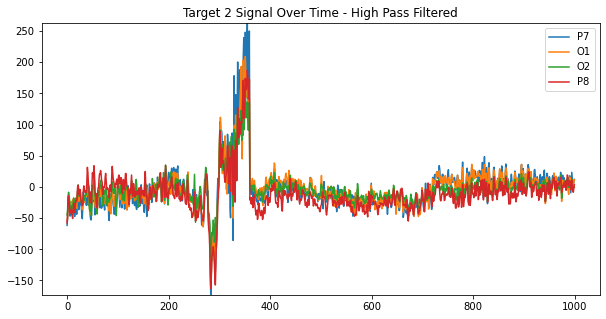

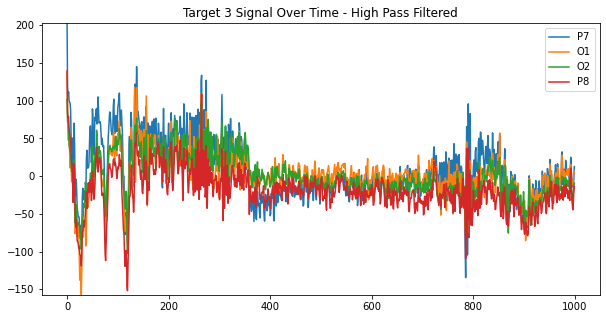

In [10]:
plot_time_all(targets, extend_title='- High Pass Filtered')

In [11]:
# averages_all_targets = averaging(targets)
# for i in range(num_targets):
#     plot_target_average(averages_all_targets[i], i)

In [12]:
def getReferenceSignals(frequencies, num_seconds):
    ref_signals = []
    for freq in frequencies:
        ref_signals.append(generateRefSignal(128 * num_seconds, freq))
    return np.asarray(ref_signals)

def generateRefSignal(samples, freq):
    signals = []
    t = np.arange(0, (samples/128.0), step=1.0/128.0)
    signals.append(np.sin(np.pi*2*freq*t))
    signals.append(np.cos(np.pi*2*freq*t))
    signals.append(np.sin(np.pi*4*freq*t))
    signals.append(np.cos(np.pi*4*freq*t))

    return np.asarray(signals)

def findCorr(data, target):
    result = np.zeros([(target.shape)[0], 2]) # num_targets x number of canonical corrs
    cca = CCA(n_components=2)
    for i in range(0, (target.shape)[0]):
        cca.fit(data, np.squeeze(target[i,:,:]).T)
        a, b = cca.transform(data, np.squeeze(target[i,:,:]).T)
        # a and b shape = 128 x (n_components)
        # print('a shape {} \t b shape {}'.format(a.shape, b.shape))
        corr_arr0 = np.corrcoef(a[:,0], b[:,0])
        corr_arr1 = np.corrcoef(a[:,1], b[:,1])
        # print('target {}:\tcorr0 = {}\tcorr1 = {}'.format(i, corr_arr0[0,1], corr_arr1[0,1]))
        corr = corr_arr0[0, 1]
        corr2 = corr_arr1[0, 1]
        result[i][0] = corr
        result[i][1] = corr2
    return result

def getChunkFeatures(data, ref_signals):
    corrs = findCorr(data, ref_signals)
    # print(corrs.flatten())
    return corrs.flatten(order='F')

In [13]:
def check_targets(num_seconds=2, cheating=False):
    # taking raw data from EEG, filtering it, making predictions, and generating CCA features
    num_chunks = len(original_data[0].index) // (128 * num_seconds)
    features = np.zeros([num_chunks * num_targets, 9])
    ref_signals = getReferenceSignals(frequencies, num_seconds=num_seconds)
    channels = ['P7', 'O1', 'O2', 'P8']
    chunk = 0
    for target in range(len(original_data)):
        predictions = []
        row = 0
        print('\n' + '-'*20 + 'Checking Target {} against reference signals ...'.format(target) + '-'*20 + '\n')
        while True:
            if row >= len(original_data[target].index) or len(original_data[target].index) - row < 128 * num_seconds:
                # print("done checking targets. row at {}".format(row))
                break
            # print('Checking samples {} to {} ...'.format(row, row+128*num_seconds))
            data = np.asarray(original_data[target][channels][row:row+128*num_seconds]) # 128 x 4
            
            # filter chunk
            for i, channel in enumerate(data.T):
                
                if cheating:
                    band_edges = [frequencies[target] - 1.0, frequencies[target] + 1.0]
                    # data.T[i] = butter_band(channel, lowcut=band_edges[0], highcut=band_edges[1])
                else:
                    # data.T[i] = butter_filter(channel)
                    channel = car_filter_one_channel(channel)
                    data.T[i] = butter_highpass(channel)

            features_row = getChunkFeatures(data, ref_signals)
            features_row = np.append(features_row, target)
            features[chunk] = features_row
            # print(features[chunk])
            prediction = np.argmax(features_row[:4])
            # print("Predicted target {}".format(prediction))
            predictions.append(prediction)
            row += 128 * num_seconds
            chunk += 1
        accuracy = round(100 * predictions.count(target) / len(predictions))
        print('Accuracy for target {} = {} %'.format(target, accuracy))
    return features

In [14]:
features = check_targets(num_seconds=1, cheating=False)


--------------------Checking Target 0 against reference signals ...--------------------

Accuracy for target 0 = 4 %

--------------------Checking Target 1 against reference signals ...--------------------

Accuracy for target 1 = 19 %

--------------------Checking Target 2 against reference signals ...--------------------

Accuracy for target 2 = 19 %

--------------------Checking Target 3 against reference signals ...--------------------

Accuracy for target 3 = 33 %


In [15]:
corrs = features[:, :-1]
labels = [int(i) for i in features[:, -1]]
X_train, X_test, y_train, y_test = train_test_split(corrs, labels, test_size=0.20, random_state=42)

In [16]:
# training data is based on correlation values and the correct target

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print('Accuracy: ', metrics.accuracy_score(y_test, pred))
print('Predicted actions:')
print([int(i) for i in pred])
print('Correct actions:')
print([int(i) for i in y_test])

Accuracy:  0.35714285714285715
Predicted actions:
[3, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 3, 0, 1, 1, 1, 3, 0, 1, 2, 1, 0, 0, 1, 2, 2, 3, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 3, 2, 3, 2, 2, 2, 3, 1]
Correct actions:
[0, 1, 3, 3, 2, 0, 2, 2, 2, 2, 3, 1, 3, 2, 0, 3, 0, 1, 1, 2, 3, 3, 2, 3, 0, 1, 0, 1, 3, 3, 0, 1, 0, 3, 2, 0, 0, 0, 1, 2, 1, 3, 3, 1, 2, 3, 2, 0, 3, 1, 1, 0, 0, 1, 2, 0]
